# load data

In [1]:
train_dir = './2000/train'
valid_dir = './2000/validation'

In [2]:
import tensorflow as tf
tf.__version__

'2.6.2'

# build Model

In [7]:
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.keras.applications.xception import Xception
conv_base = Xception(include_top=False,
                     weights='imagenet',
                     input_shape=(275,205,3))

In [3]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 275, 205, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 137, 102, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 137, 102, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 137, 102, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [4]:
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 154


In [5]:
conv_base.trainable=True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'add_8':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [6]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 43


In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=7 * 9 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 9, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 129024)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33030400  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 53,893,422
Trainable params: 43,048,278
Non-trainable params: 10,845,144
_________________________________________________________________


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (275,205),
    batch_size=32,
    class_mode = 'categorical')

valid_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (275, 205),
    batch_size = 32,
    class_mode = 'categorical')

Found 12000 images belonging to 6 classes.
Found 4800 images belonging to 6 classes.


In [10]:
!mkdir my_log_dir

In [11]:
from tensorflow import keras

callbacks_list = [
                  keras.callbacks.ModelCheckpoint(
                      filepath='Xception_least_vl.h5',
                      monitor='val_loss',
                      save_best_only=True,
                  ),
                  keras.callbacks.ModelCheckpoint(
                      filepath='Xception_latest.h5',
                      save_best_only=False,
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss',
                      factor=0.5,
                      patience=3,
                  ),
                  keras.callbacks.TensorBoard(
                      log_dir='my_log_dir',
                      histogram_freq=1,
                  )
]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=2e-5),
              metrics = ['acc'])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=375,
                    epochs=40,
                    validation_data=valid_generator,
                    validation_steps=150,
                    callbacks=callbacks_list)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
375/375 [==============================] - 308s 804ms/step - loss: 1.4696 - acc: 0.4121 - val_loss: 1.1846 - val_acc: 0.5494
Epoch 2/40
375/375 [==============================] - 300s 799ms/step - loss: 1.0775 - acc: 0.5980 - val_loss: 1.0461 - val_acc: 0.6127
Epoch 3/40
375/375 [==============================] - 300s 800ms/step - loss: 0.9318 - acc: 0.6543 - val_loss: 0.9751 - val_acc: 0.6467
Epoch 4/40
375/375 [==============================] - 298s 795ms/step - loss: 0.8453 - acc: 0.6901 - val_loss: 0.9191 - val_acc: 0.6594
Epoch 5/40
375/375 [==============================] - 299s 796ms/step - loss: 0.7889 - acc: 0.7114 - val_loss: 0.9633 - val_acc: 0.6573
Epoch 6/40
375/375 [==============================] - 299s 796ms/step - loss: 0.7308 - acc: 0.7358 - val_loss: 0.9446 - val_acc: 0.6740
Epoch 7/40
375/375 [==============================] - 299s 797ms/step - loss: 0.6913 - acc: 0.7495 - val_loss: 0.9317 - val_acc: 0.6765
Epoch 8/40
375/375 [============================

In [14]:
%load_ext tensorboard
%tensorboard --logdir ./my_log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


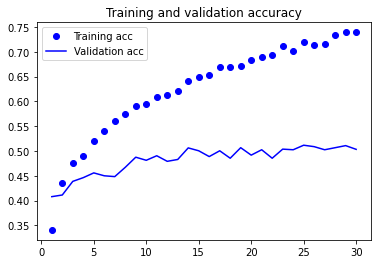

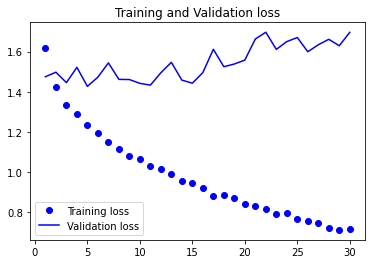

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [11]:
model.save('/home/lab03/models/except_hurt_Xception_aug.h5')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
